This notebook is my first attempt at stochastic estimation of salinity using rjmcmc AEM inversions and EC measurements on pore fluids collected in the East Kimberley


In [1]:
%matplotlib inline
#widget

In [2]:
import pandas as pd
import rasterio
from sqlite3 import dbapi2 as sqlite
import numpy as np
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils, grid_utils
from shapely.geometry import Polygon, shape
import netCDF4
import math
import time
import os, glob
import gc
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils import points2convex_hull
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
from scipy import interpolate, stats
import sqlalchemy as db
from sqlalchemy import create_engine, event
import matplotlib.pyplot as plt
from hydrogeol_utils.db_utils import makeCon, closeCon
import math

In [3]:
# Birng the AEM data into memory
cond_path = r"C:\Users\PCUser\Desktop\AEM\rjmcmc\EastKimberley_rjmcmc.nc"

rj_dat = netCDF4.Dataset(cond_path, 'r')

In [5]:
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\OrdK_WB_MGA52.nc"

lci_dat = netCDF4.Dataset(infile)

lci_coords = np.column_stack((lci_dat['easting'][:],
                          lci_dat['northing'][:]))



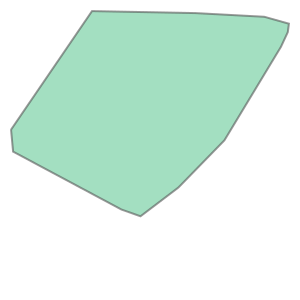

In [6]:
# Create a convex hull around the Keep River area based on line 3xxx,xxx

# Initialise an instance of the netCDF point and line utility classes
cond_line_utils = NetCDFLineUtils(rj_dat)
cond_point_utils = NetCDFPointUtils(rj_dat)

# Display the lines for the conductivity mode

lines = cond_line_utils.line

# Get the utm coordinates using the mask created above

utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

# Get the convex hull of the subset
convex_hull = points2convex_hull(aem_coords)


# Create a shapely object of the convex hull
Keep_poly = Polygon(convex_hull)

Keep_poly

In [7]:
# Extract data from the borehole spatialite database

# Extract borehole data from the database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite"

SPATIALITE_PATH = r'C:\mod_spatialite-NG-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)


connection = makeCon(DB_PATH)

Connected to C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


In [8]:
# Extract boreholes from within this geometry

df_header = borehole_utils.extract_boreholes_within_geometry('borehole', connection,
                                                             Keep_poly.wkt, columns = ['borehole_id', 'Easting','Northing',
                                                                                      'Ground_elevation_mAHD', 'EC_pH_acquired', 'geometry', 'geom'],
                                                             verbose = True)
# Keep only bores with both EC

mask = df_header['EC_pH_acquired'] == 1

df_header= df_header[mask]


Select b.borehole_id, b.Easting, b.Northing, b.Ground_elevation_mAHD, b.EC_pH_acquired, b.geometry, b.geom from borehole b  where within(b.geom,GeomFromText('POLYGON ((488128.1875000136 8250442.499944453, 480017.0000000236 8253308.999944538, 433773.1875000782 8278023.499945267, 432931.3125000796 8287154.999945535, 433001.593750078 8287538.499945547, 467446.3125000329 8337972.999947037, 511489.0937499862 8337131.999947011, 540942.1874999559 8335554.999946964, 551443.3124999437 8332595.499946878, 550987.624999944 8329028.999946772, 548067.1249999468 8322763.999946587, 523936.8124999695 8282856.999945406, 504490.093749991 8262904.499944819, 504189.4062499959 8262633.499944811, 488128.1875000136 8250442.499944453))'));


In [10]:
outfile = r"C:\Users\PCUser\Desktop\EK_data\salinity_mapping\salinity_map\Keep_borehole_header.csv"

df_header.to_csv(outfile, index=False)

In [12]:
rj_coords = np.column_stack((rj_dat['easting'][:].data,
                             rj_dat['northing'][:].data,))

# Now get the netcdf index of the nearest point

# Extract the AEM conductivity using nearest neighbour
distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']],
                                                          aem_coords,
                                                          points_required = 1,# return 1 closest point
                                                          max_distance = 250.)
# Remove nulls which are >250m from a FID
mask = np.isfinite(distances)

enos = df_header['borehole_id'].values

indices = indices[mask]

df_header = df_header[mask]

df_header['rj_dat_ind'] = indices



lci_coords = np.column_stack((lci_dat['easting'][:].data,
                             lci_dat['northing'][:].data,))

# Extract the AEM conductivity using nearest neighbour
distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']],
                                                          lci_coords,
                                                          points_required = 1,# return 1 closest point
                                                          max_distance = 250.)
# Remove nulls which are >250m from a FID
mask = np.isfinite(distances)

indices = indices[mask]
df_header = df_header[mask]

df_header['lci_dat_ind'] = indices


In [18]:
# Now we want to extract all the pmaps for each point

rj_dat#['copndu']

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 432931.3125
    geospatial_east_max: 551443.3125
    geospatial_east_units: m
    geospatial_north_min: 8250442.5
    geospatial_north_max: 8337973.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file rjmcmc.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 0.19
    geospatial_vertical_max: 151.42
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\EK_data\AEM\garjmcmcmtdem\combined\rjmcmc.dat using definitions file C:\Users\PCUser\Desktop\EK_data\AEM\garjmcmcmtdem\combined\rjmcmc.dfn
    date_created: 2020-02-03T14:44:06.426738
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_bounds: POLYGON((128.8891 -15.8248, 128.8134 -15.7988, 128.3823 -15.57

In [14]:
# First import all the datasets based on our enos (primary key)

df_EC = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'borehole_id'],
                                                       connection, enos, verbose = True).merge(df_header, on = 'borehole_id')

#df_EC['EC_uncert'] = 0.05 * df_EC['EC'].values

select t.Depth, t.EC, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (635728,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635747,635748,635749,635921);


In [15]:
def extract_data():
    """
    FUnction for extracting all the AEM data from the netCDF files
    """

    freq = rj_dat['conductivity_bin_count'][point_ind_rj].data.astype(np.float)

    cond_pdf = freq / freq.sum(axis =1)[0]

    cond_pdf[cond_pdf == 0] = np.nan
    
    cp_freq = rj_dat['change_point'][point_ind_rj].data.astype(np.float)
    
    cp_pdf = cp_freq / freq.sum(axis =1)[0]
    
    laybins = rj_dat['nlayer_bin_count'][point_ind_rj].data
    
    lay_prob = laybins / freq.sum(axis =1)[0]
    
    cond_cells = rj_dat["conductivity_cells"][:].data
    
    depth_cells = rj_dat['layer_top_depth'][point_ind_rj].data
    
    extent = [cond_cells.min(), cond_cells.max(), depth_cells.max(), depth_cells.min()]
    
    mean = rj_dat['conductivity_mean'][point_ind_rj].data
    p10 = rj_dat['conductivity_p10'][point_ind_rj].data
    p50 = rj_dat['conductivity_p50'][point_ind_rj].data
    p90 = rj_dat['conductivity_p90'][point_ind_rj].data
    
    lci_cond = lci_dat['conductivity'][point_ind_lci].data
    lci_depth_top = lci_dat['layer_top_depth'][point_ind_lci].data
    
    lci_doi = lci_dat['depth_of_investigation'][point_ind_lci].data
    
    misfit = rj_dat['misfit'][point_ind_rj].data
    sample_no = rj_dat['rj_sample_number'][:].data
    
    burnin = rj_dat["nburnin"][point_ind_rj].data
    nsamples = rj_dat['nsamples'][point_ind_rj].data
    nchains = rj_dat['nchains'][point_ind_rj].data
    
    line_ind = rj_dat['line_index'][point_ind_rj].data
    line = int(rj_dat['line'][line_ind].data)
    
    return {'conductivity_pdf': cond_pdf, "change_point_pdf": cp_pdf, "conductivity_extent": extent,
           'cond_p10': p10, 'cond_p50': p50, 'cond_p90': p90, 'cond_mean': mean, 'depth_cells': depth_cells,
           'nlayer_bins': laybins, 'nlayer_prob': lay_prob, 'nsamples': nsamples, 'ndata': rj_dat['n_data'][:].data,
           "nchains": nchains, 'burnin': burnin, 'misfit': misfit, 'sample_no': sample_no, 'cond_cells': cond_cells, 'lci_cond': lci_cond,
           'lci_depth_top': lci_depth_top, 'lci_doi': lci_doi, 'line': line}

def EC_plot(D, df_boreEC, outfile = None):
    fig = plt.figure(figsize = (12,10))

    # These are for interactive widget mode
    fig.canvas.layout.width = '6in'
    fig.canvas.layout.height= '5in'

    ax1 = fig.add_axes([0.05, 0.1, 0.35, 0.8])
    ax2 = fig.add_axes([0.45, 0.1, 0.2, 0.8])
    ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2])
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    cbar_ax1 = fig.add_axes([0.05, 0.05, 0.35, 0.01])


    # Plot probability map
    
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')
    
    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')

    ax1.legend(loc = 3)
    
    # Add EC to the plot
    
    logEC = np.log10(df_boreEC['EC'].values)
    EC_depth = df_boreEC['Depth'].values
    
    ax1.scatter(logEC, EC_depth, c = 'k', marker = '+')
    
    lims = np.concatenate((logEC, np.array(ax1.get_xlim())))
    
    ax1.set_xlim(np.min(lims) - 0.5, np.max(lims) + 0.5)

    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#(100.,0)
    ax2.legend()
    ax2.grid(which = 'both')
    
    ax1.set_ylim(np.max(EC_depth + 10), 0.)

    sample = D['sample_no'][:]
    
    # Ax3 can be for number of layers
    
    ax3.bar(rj_dat['nlayers_cells'][:].data, height = D['nlayer_prob'])
    ax3.set_xlabel ("no of layers")
    
    # Add the misfit
    for i in range(D['misfit'].shape[0]):
       
        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")
    
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)
    
    # Add any existing splits
    
    for item in picks:
        if item[0] == bore_id:
            ax1.plot(ax1.get_xlim(), [item[1], item[1]], c = 'green',
                     label = 'split')
    
    return fig


picks = []

def onclick(event):
    if event.xdata != None and event.ydata != None:
        picks.append([bore_id, np.round(event.ydata/2.,0)*2])

In [121]:
bores = df_EC['borehole_id'].unique()

[[635728, 12.0],
 [635728, 22.0],
 [635728, 30.0],
 [635730, 2.0],
 [635730, 14.0],
 [635730, 24.0],
 [635730, 34.0],
 [635730, 40.0]]

In [118]:

plt.close('all')

bore_id = bores[0]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

83


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [120]:

#plt.close('all')

bore_id = bores[1]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

87


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [123]:

#plt.close('all')

bore_id = bores[2]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

43


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [125]:

#plt.close('all')

bore_id = bores[3]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

61


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [127]:

#plt.close('all')

bore_id = bores[4]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

73


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [129]:

#plt.close('all')

bore_id = bores[5]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

19


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [131]:

#plt.close('all')

bore_id = bores[6]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

84


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [133]:
bore_id = bores[7]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

48


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [135]:
bore_id = bores[8]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

40


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [137]:
bore_id = bores[9]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask],
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

61


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [141]:
bore_id = bores[10]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask].dropna(),
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

58


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [143]:
bore_id = bores[11]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask].dropna(),
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

46


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [145]:
bore_id = bores[12]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask].dropna(),
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

43


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [147]:
bore_id = bores[13]

mask = df_EC['borehole_id'] == bore_id

print(len(df_EC['borehole_id'][mask]))

point_ind_rj = df_EC[mask]['rj_dat_ind'].iloc[0]

point_ind_lci = df_EC[mask]['lci_dat_ind'].iloc[0]

D = extract_data()

fig = EC_plot(D, df_EC[mask].dropna(),
        outfile = None)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

32


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10


In [148]:
# Now subset the data based on the splits


df_picks = pd.DataFrame(columns = ['borehole_id', 'split_depth'], data = picks)

In [155]:
df_picks

,borehole_id,split_depth
0,635728,12.0
1,635728,22.0
2,635728,30.0
3,635730,2.0
4,635730,14.0
5,635730,24.0
6,635730,34.0
7,635730,40.0
8,635733,18.0
9,635733,24.0


In [236]:

n_cond_bins = rj_dat.dimensions['conductivity_cells'].size

df_final = pd.DataFrame(columns = ['borehole_id', 'Depth_from', 'Depth_to', 'n_EC',
                                  'log_EC_mean', 'log_EC_stderr'] + ['cond_' + str(i+1) for i in range(n_cond_bins)])

# Iterate through the bores and get statistics for each split

for item in bores:
    splits = list(df_picks[df_picks['borehole_id'] == item]['split_depth'])
    
    df_EC_bore = df_EC[df_EC['borehole_id'] == item]
    
    #add the min and max depth using the EC data
    
    splits.insert(0, math.floor(df_EC_bore['Depth'].min()/2.) *2.)
    
    splits.append(math.ceil(df_EC_bore['Depth'].max()/2.) * 2.)
    
    # Now for each interval
    
    for i in range(len(splits) - 1):
        du, dl = splits[i], splits[i+1]
        
        # Get the EC values from between these intervals
        
        ECs = np.log10(df_EC_bore[(df_EC_bore['Depth'] > du) & (df_EC_bore['Depth'] < dl)]['EC'])
        
        dat = {'borehole_id': item, 'Depth_from': du, 'Depth_to': dl,
                  'log_EC_mean': np.mean(ECs), 'log_EC_stderr': np.std(ECs)/np.sqrt(len(ECs))}
        
        # Now we want to get our conductivity histogram
        
        point_ind_rj = df_EC_bore['rj_dat_ind'].iloc[0]
        
        # Get our layer indices
        
        layer_inds = np.arange(np.where(np.isclose(rj_dat['layer_top_depth'][point_ind_rj],
                                                  du))[0][0],
                             np.where(np.isclose(rj_dat['layer_top_depth'][point_ind_rj],
                                                 dl))[0][0] + 1, 1)
        
        # Now sum the counts across the layers a
        
        cond_counts = rj_dat['conductivity_bin_count'][point_ind_rj, layer_inds].sum(axis = 0)
        
        # Add each column to dictionary
        for i in range(rj_dat.dimensions['conductivity_cells'].size):
            dat['cond_' + str(i+1)] = cond_counts[i]
        
        dat['n_EC'] = len(ECs)
        
        # Append dictionary to data frame
        
        df_final = df_final.append(dat, ignore_index = True)
        

In [237]:
df_final.to_csv(r"C:\Users\PCUser\Desktop\EK_data\salinity_mapping\EK_EC_cond_joint_pdf_pmap.csv",
               index = False)